### tiff2nc
Converts geoTiff files from soilGrids to stacked .nc files for use in mksurf

Data available at https://files.isric.org/soilgrids/latest/data_aggregated/5000m/

Metadata (including the DOI for citations) can be found here: https://data.isric.org/

retrieved with the following command:

`wget -r --no-parent -A 'bdod_*.tif' https://files.isric.org/soilgrids/latest/data_aggregated/5000m/bdod/' `

Finally, information about units & conversions for each variable are here: https://www.isric.org/explore/soilgrids/faq-soilgrids#What_do_the_filename_codes_mean


In [1]:
import xarray as xr
import rioxarray
from affine import Affine
from glob import glob
import dask
from distributed import wait
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

%matplotlib inline

### Get some workers

In [2]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='P93300641', # Input your project ID here
        walltime='1:00:00', # Amount of wall time
        interface='ib0', # Interface to use
    )

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })

    client = Client(cluster)
    return cluster, client

In [3]:
cluster, client = get_ClusterClient(nmem='1GB')
cluster.scale(20)
cluster

/glade/u/home/wwieder/miniconda3/envs/tiff2nc/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wwieder/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.48:42496,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wwieder/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Quick look at a single soil property
#### open as rioxarray to bring in meta and projection data

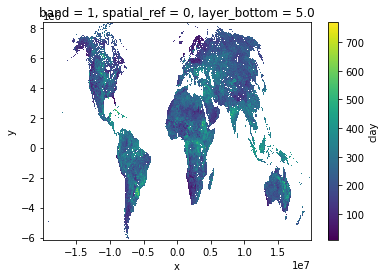

In [8]:
path ='/glade/scratch/wwieder/SoilGrids/soilgrids/latest/data_aggregated/5000m/'
depth = ['0-5','5-15','15-30','30-60','60-100','100-200']
layer_top =    [0.,5. ,15.,30.,60. ,100.]
layer_bottom = [5.,15.,30.,60.,100.,200.]
var = 'clay'
infile = [path + var + '/' + var +"_"+ depth[d] + 'cm_mean_5000.tif' 
          for d in range(len(depth))]
rds = xr.concat([rioxarray.open_rasterio(infile[f]) for f in range(len(infile))],'layer_bottom')
rds = rds.squeeze().assign_coords(layer_bottom=layer_bottom)
rds.name = var
rds.where(rds>=0).isel(layer_bottom=0).plot();

### Loop over properties & write .nc files

<xarray.DataArray 'x' (x: 7908)>
array([-179.977232, -179.931712, -179.886193, ...,  179.855275,  179.900795,
        179.946315])
Coordinates:
  * x            (x) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 179.9
    band         int64 1
    spatial_ref  int64 0
Attributes:
    axis:           X
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east

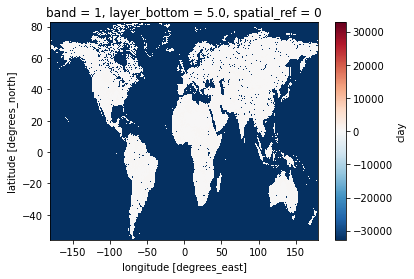

In [9]:
temp = rds.rio.reproject('EPSG:4326')
temp.isel(layer_bottom=0).plot() ;
temp.x

<xarray.DataArray 'x' (x: 7106)>
array([-79030168.537342, -79006085.284334, -78982002.031326, ...,
        92033177.577522,  92057260.83053 ,  92081344.083538])
Coordinates:
  * x            (x) float64 -7.903e+07 -7.901e+07 ... 9.206e+07 9.208e+07
    band         int64 1
    spatial_ref  int64 0
Attributes:
    axis:           X
    long_name:      x coordinate of projection
    standard_name:  projection_x_coordinate
    units:          0.30480060960121924 metre

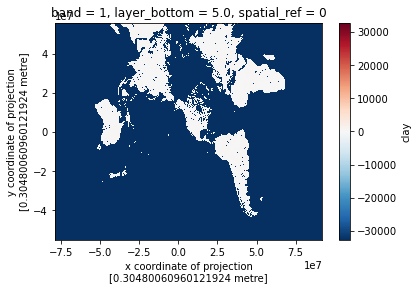

In [10]:
temp2 = rds.rio.reproject('EPSG:6422')
#temp2 = rds.rio.reproject('EPSG:9055')
temp2.isel(layer_bottom=0).plot() ;
temp2.x

In [11]:
print(temp.x[0].values - temp.x[1].values)
temp.x[-20].values - temp.x[-19].values

-0.04551960876054295


-0.04551960876057137

In [12]:
print(temp2.x[0].values - temp2.x[1].values)
temp2.x[100].values - temp2.x[101].values

-24083.25300785899


-24083.253007873893

In [20]:
path ='/glade/scratch/wwieder/SoilGrids/soilgrids/latest/data_aggregated/5000m/'
depth = ['0-5','5-15','15-30','30-60','60-100','100-200']
layer_top =    [0.,5. ,15.,30.,60. ,100.]
layer_bottom = [5.,15.,30.,60.,100.,200.]

Var = ['bdod','cec','cfvo','clay','nitrogen','ocd','phh2o','sand','soc','silt']
Var = ['silt']

for v in range(len(Var)):
    var = Var[v]
    infile = [path + var + '/' + var +"_"+ depth[d] + 'cm_mean_5000.tif' 
          for d in range(len(depth))]


    ## Define attributes for each property
    if var == 'bdod':
        long_name, conversion, units = 'Bulk density of the fine earth fraction', 100, 'kg/dm³'
    if var == 'cec':
        long_name, conversion, units = 'Cation Exchange Capacity', 10, 'cmol(c)/kg'
    if var == 'cfvo':
        long_name, conversion, units = 'Volumetric fraction of coarse fragments (> 2 mm)', 10, 'cm3/100cm3 (vol%)'  
    if var == 'clay':
        long_name, conversion, units = 'Proportion of clay particles (< 0.002 mm) in the fine earth fraction', 10, 'g/100g (%)'  
    if var == 'nitrogen':
        long_name, conversion, units = 'Total nitrogen (N)', 100, 'g/kg'
    if var == 'ocd':
        long_name, conversion, units = 'Organic carbon density', 10, 'kg/m³'
    if var == 'phh2o':
        long_name, conversion, units = 'Soil pH', 10, 'pH'    
    if var == 'sand':
        long_name, conversion, units = 'Proportion of sand particles (> 0.05 mm) in the fine earth fraction', 10, 'g/100g (%)'
    if var == 'silt':
        long_name, conversion, units = 'Proportion of silt particles (≥ 0.002 mm and ≤ 0.05 mm) in the fine earth fraction	', 10, 'g/100g (%)'
    if var == 'soc':
        long_name, conversion, units = 'Soil organic carbon content in the fine earth fraction', 10, 'g/kg'

    ## Open as rioxarray to bring in meta and projection data
    rds = xr.concat([rioxarray.open_rasterio(infile[f]) for f in range(len(infile))],'layer_bottom')
    rds = rds.squeeze().assign_coords(layer_bottom=layer_bottom)
    rds.name = var
    FillValue = rds.attrs['_FillValue']
    scale_factor = rds.attrs['scale_factor']
    rds = rds/conversion
    rds.attrs['_FillValue'] = FillValue/conversion
    print(var + ' scale factor '+str(scale_factor)+ ', conversion '+str(conversion))

    ## Shift projection, clean up dimensions
    rds_lonlat = rds.rio.reproject("EPSG:4326")
    rds_lonlat = rds_lonlat.rename({'x':'lon','y':'lat'})
    rds_lonlat = rds_lonlat.drop(['spatial_ref','band'])
    rds_lonlat.layer_bottom.attrs['axis'] = 'Z'
    rds_lonlat.layer_bottom.attrs['units'] = 'cm'
    rds_lonlat.layer_bottom.attrs['long_name'] = 'depth to bottom of soil layer'
    rds_lonlat.attrs['long_name'] = long_name 
    rds_lonlat.attrs['units'] = units 


    ## Write out .nc file
    fout = '/glade/scratch/wwieder/SoilGrids/ncMerged/' + var +"_0-300_mean_5000.nc"
    rds_lonlat.to_netcdf(fout)
    print('wrote '+fout)

    #rds_lonlat.where(rds_lonlat !=rds_lonlat.attrs['_FillValue']).isel(layer_bottom=0).plot();
    #rds_lonlat

silt scale factor 1.0, conversion 10
wrote /glade/scratch/wwieder/SoilGrids/ncMerged/silt_0-300_mean_5000.nc


### quick check to see if .nc files read back in correctly.

<bound method ImplementsDatasetReduce._reduce_method.<locals>.wrapped_func of <xarray.Dataset>
Dimensions:       (lat: 3047, layer_bottom: 6, lon: 7908)
Coordinates:
  * lat           (lat) float64 82.7 82.65 82.61 82.56 ... -55.88 -55.93 -55.97
  * layer_bottom  (layer_bottom) float64 5.0 15.0 30.0 60.0 100.0 200.0
  * lon           (lon) float64 -180.0 -179.9 -179.9 ... 179.9 179.9 179.9
Data variables:
    nitrogen      (layer_bottom, lat, lon) float64 ...
    bdod          (layer_bottom, lat, lon) float64 ...
    cec           (layer_bottom, lat, lon) float64 ...
    cfvo          (layer_bottom, lat, lon) float64 ...
    clay          (layer_bottom, lat, lon) float64 ...
    ocd           (layer_bottom, lat, lon) float64 ...
    phh2o         (layer_bottom, lat, lon) float64 ...
    sand          (layer_bottom, lat, lon) float64 ...
    silt          (layer_bottom, lat, lon) float64 ...
    soc           (layer_bottom, lat, lon) float64 ...
Attributes:
    NCO:                     

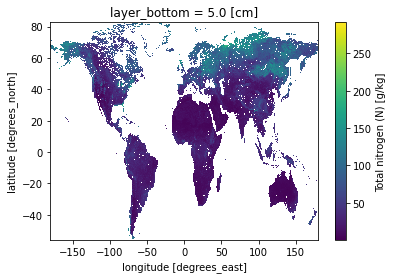

In [4]:
#var='silt'
#fin = '/glade/scratch/wwieder/SoilGrids/ncMerged/' + var +"_0-300_mean_5000.nc"
#ds = xr.open_dataset(fin)

fin2 = '/glade/scratch/wwieder/SoilGrids/ncMerged/SoilGrids_mean_5000_merged.nc'
ds2 = xr.open_dataset(fin2)
ds2.nitrogen.isel(layer_bottom=0).plot() ;
ds2.var

<xarray.DataArray ()>
array(2.)
<xarray.DataArray 'bdod' (layer_bottom: 6, lat: 3047, lon: 7908)>
[144574056 values with dtype=float64]
Coordinates:
  * lat           (lat) float64 82.7 82.65 82.61 82.56 ... -55.88 -55.93 -55.97
  * layer_bottom  (layer_bottom) float64 5.0 15.0 30.0 60.0 100.0 200.0
  * lon           (lon) float64 -180.0 -179.9 -179.9 ... 179.9 179.9 179.9
Attributes:
    long_name:     Bulk density of the fine earth fraction
    units:         kg/dm³
    grid_mapping:  spatial_ref
<xarray.DataArray 'cfvo' (layer_bottom: 6, lat: 3047, lon: 7908)>
[144574056 values with dtype=float64]
Coordinates:
  * lat           (lat) float64 82.7 82.65 82.61 82.56 ... -55.88 -55.93 -55.97
  * layer_bottom  (layer_bottom) float64 5.0 15.0 30.0 60.0 100.0 200.0
  * lon           (lon) float64 -180.0 -179.9 -179.9 ... 179.9 179.9 179.9
Attributes:
    long_name:     Volumetric fraction of coarse fragments (> 2 mm)
    units:         cm3/100cm3 (vol%)
    grid_mapping:  spatial_ref


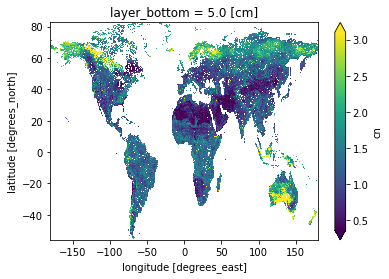

In [22]:
depth = xr.DataArray([0.05,0.1,0.15,0.3,0.4,1.],dims = "layer_bottom", 
                     coords = dict(later_bottom=ds2.layer_bottom) )# m
print(sum(depth))
print(ds2.bdod)
print(ds2.cfvo)
ds2['cn'] = ds2.soc / ds2.nitrogen
ds2.cn.isel(layer_bottom=0).plot(robust=True) ;

<xarray.DataArray 'layer_bottom' (layer_bottom: 5)>
array([  5.,  15.,  30.,  60., 100.])
Coordinates:
  * layer_bottom  (layer_bottom) float64 5.0 15.0 30.0 60.0 100.0
    later_bottom  (layer_bottom) float64 5.0 15.0 30.0 60.0 100.0
Attributes:
    axis:       Z
    units:      cm
    long_name:  depth to bottom of soil layer


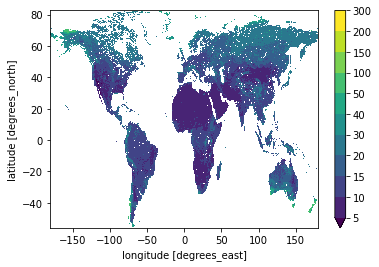

In [51]:
ocd = (ds2.ocd * depth).isel(layer_bottom=slice(0,5))
print(ocd.layer_bottom)
ocd = ocd.sum('layer_bottom') 
levels = [5, 10, 15, 20, 30, 40, 50, 100, 150, 200, 300]
ocd.where(ocd>0).plot(levels=levels, cbar_kwargs={"ticks": levels}) ;

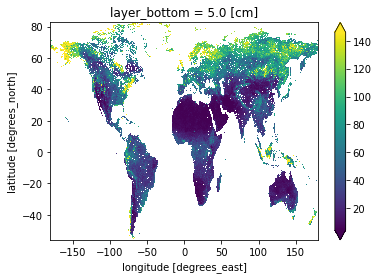

In [48]:
ocd2 = ds2.soc*(1-(ds2.cfvo/100))*ds2.bdod  #convert gC/kg soil to kgC/m2
#ocd2 = ds2.soc*ds2.bdod  #convert gC/kg soil to kgC/m2
ocd2.isel(layer_bottom=0).plot(robust=True) ;

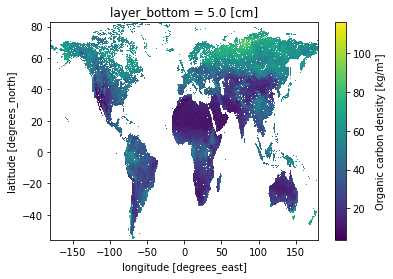

In [39]:
ds2.ocd.isel(layer_bottom=0).plot() ;

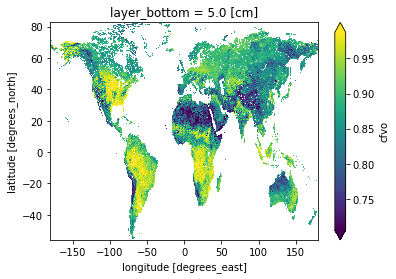

In [46]:
(1-(ds2.cfvo/100)).isel(layer_bottom=0).plot(robust=True)

(-100.0, 35000.0)

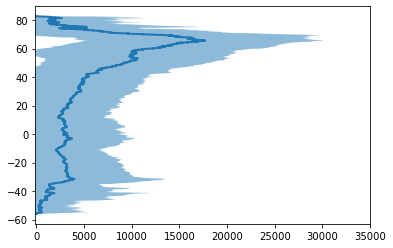

In [60]:
import matplotlib.pyplot as plt
x = ocd.mean(dim='lon') * 1000
xSD = ocd.std(dim='lon') * 1000

plt.plot(x,ocd.lat,lw=2)
plt.fill_betweenx(ocd.lat, (x-xSD), (x+xSD), alpha=0.5)
plt.xlim(-100,3.5e4)

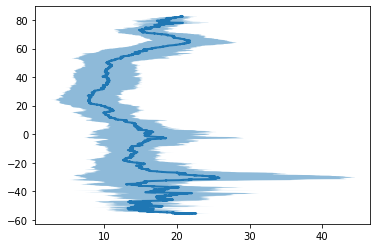

In [55]:
x = ds2.cn.isel(layer_bottom=0).mean(dim='lon') * 10
xSD = ds2.cn.isel(layer_bottom=0).std(dim='lon') * 10
x2 = ds2.cn.isel(layer_bottom=1).mean(dim='lon') * 10
plt.plot(x,ocd.lat,lw=2)
plt.fill_betweenx(ocd.lat, (x-xSD), (x+xSD), alpha=0.5)
#plt.plot(x2,ocd.lat,lw=2, color='b');

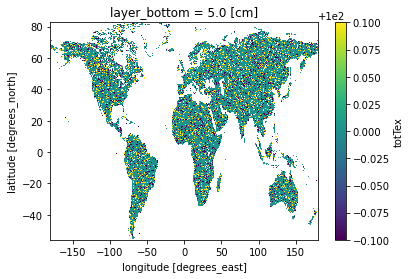

In [6]:
ds2['totTex'] = ds2.sand + ds2.clay + ds2.silt
ds2['totTex'].isel(layer_bottom=0).plot(robust=True) ;

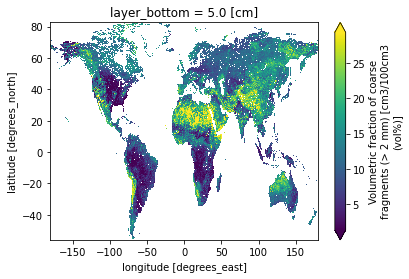

In [11]:
ds2.cfvo.isel(layer_bottom=0).plot(robust=True) ; 

In [10]:
print(ds2['totTex'].min().values)
ds2['totTex'].max().values

99.89999999999999


array(100.1)

---------------

In [7]:
# https://github.com/rasbt/watermark
%load_ext watermark
%watermark --updated --date --iversions --gitrepo --gitbranch --githash --python

Last updated: 2022-02-14

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 7.31.1

Git hash: 35e49b7bda9baef41790f5bc23396e25e6b35af1

Git repo: git@github.com:wwieder/ctsm_py.git

Git branch: master

json     : 2.0.9
sys      : 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0]
xarray   : 0.20.2
rioxarray: 0.8.0
dask     : 2021.10.0
pandas   : 1.3.5
numpy    : 1.21.5

